# Product Amount Forecast by Time

## Data

Info about this data set: https://fred.stlouisfed.org/series/IPN31152N


Units:  Index 2012=100, Not Seasonally Adjusted

Frequency:  Monthly

The industrial production (IP) index measures the real output of all relevant establishments located in the United States, regardless of their ownership, but not those located in U.S. territories.

NAICS = 31152

Source Code: IP.N31152.N

Suggested Citation:
Board of Governors of the Federal Reserve System (US), Industrial Production: Nondurable Goods: Ice cream and frozen dessert [IPN31152N], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/IPN31152N, November 16, 2019.

## Import Libraries

In [63]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams["figure.figsize"] = (10,6)
import warnings
warnings.filterwarnings("ignore")
warnings.warn("this will not show")

## Indest Data

In [64]:
df = pd.read_csv('Frozen_Dessert_Production.csv',index_col='DATE',parse_dates=True)

## Exploratory Data Analysis and Visualization

1. Implement basic steps to see how is your data looks like
2. Change the column name as "Production"
2. Plot your data and see its seasonalty

In [65]:
df.head(10)

,IPN31152N
DATE,
1972-01-01,59.9622
1972-02-01,67.0605
1972-03-01,74.2350
1972-04-01,78.1120
1972-05-01,84.7636
1972-06-01,100.5960
1972-07-01,100.1263
1972-08-01,96.3607
1972-09-01,85.8007


In [66]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 573 entries, 1972-01-01 to 2019-09-01
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   IPN31152N  573 non-null    float64
dtypes: float64(1)
memory usage: 9.0 KB


In [67]:
df.columns = ['Production']

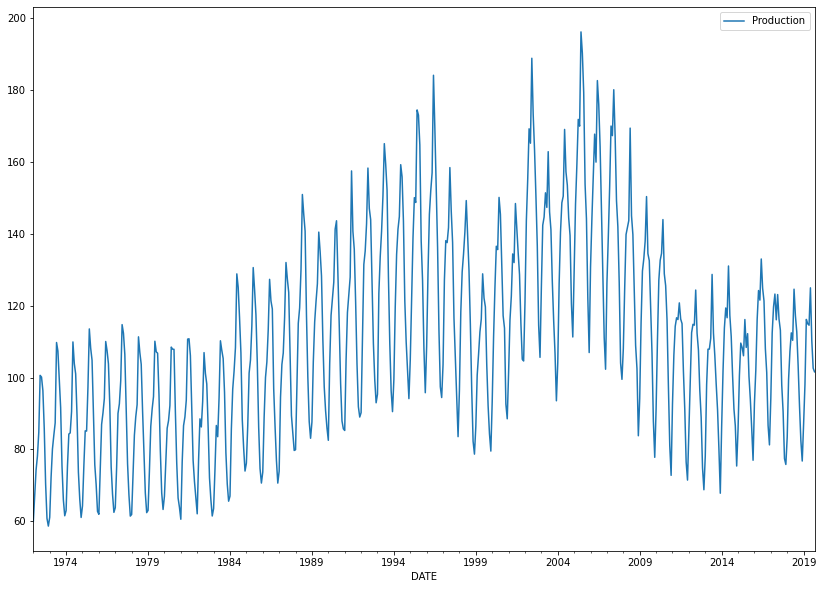

In [69]:
df.plot(figsize=(14,10));

## Preprocessing of Data

### Train Test Split

In [70]:
test_size = 18
test_ind = len(df)- test_size

In [71]:
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

### Scaling

In [72]:
from sklearn.preprocessing import MinMaxScaler

In [73]:
scaler = MinMaxScaler()

In [74]:
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

## Time Series Generator

In [75]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [76]:
length = 10
generator = TimeseriesGenerator(train_scaled, train_scaled, length = length, batch_size = 1)

In [77]:
X, y = generator[0]

In [78]:
print(f'Array: \n{X.flatten()}')
print(f'Predict: \n {y}')

Array: 
[0.00947104 0.06108982 0.11326273 0.14145625 0.18982663 0.30495972
 0.30154406 0.27416065 0.19736841 0.08532665]
Predict: 
 [[0.01561588]]


## Modelling & Model Performance

### Import related libraries

In [79]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping

In [80]:
n_features = 1

### Creating Model

### with "tanh" activation function

In [81]:
model1 = Sequential()
model1.add(LSTM(150, activation = 'tanh', input_shape = (length, n_features)))
model1.add(Dense(1))
model1.compile(optimizer = 'adam', loss = 'mse')

In [82]:
model1.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 150)               91200     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 151       
Total params: 91,351
Trainable params: 91,351
Non-trainable params: 0
_________________________________________________________________


In [83]:
early_stop = EarlyStopping(monitor = 'val_loss', patience = 4)

In [84]:
validation_generator = TimeseriesGenerator(test_scaled, test_scaled, length = length, batch_size = 1)

In [85]:
model1.fit_generator(generator, epochs = 20,
                    validation_data = validation_generator,
                    callbacks = [early_stop])

Epoch 1/20
545/545 [==============================] - 6s 7ms/step - loss: 0.0202 - val_loss: 0.0022
Epoch 2/20
545/545 [==============================] - 4s 7ms/step - loss: 0.0048 - val_loss: 0.0032
Epoch 3/20
545/545 [==============================] - 5s 9ms/step - loss: 0.0046 - val_loss: 0.0030
Epoch 4/20
545/545 [==============================] - 5s 9ms/step - loss: 0.0037 - val_loss: 0.0041
Epoch 5/20
545/545 [==============================] - 4s 7ms/step - loss: 0.0037 - val_loss: 0.0037


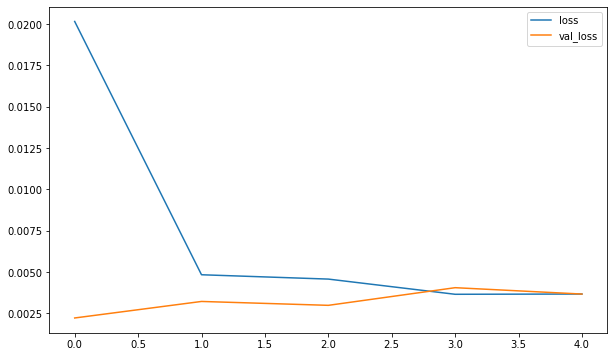

In [86]:
loss_df = pd.DataFrame(model1.history.history)
loss_df.plot();

#### Evaluate on Test Data

In [87]:
test_predictions = []

first_eval_batch = train_scaled[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    current_pred = model1.predict(current_batch)[0]
    
    test_predictions.append(current_pred) 
    
    current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis=1)

#### Inverse Transformations and Comparing

In [88]:
true_predictions = scaler.inverse_transform(test_predictions)

In [89]:
test['Predictions'] = true_predictions

In [90]:
test

,Production,Predictions
DATE,,
2018-04-01,112.4309,118.116120
2018-05-01,110.3544,125.509953
2018-06-01,124.5841,129.115517
2018-07-01,117.2215,125.260993
2018-08-01,112.6779,113.106063
2018-09-01,103.3118,94.671794
2018-10-01,92.1321,78.923014
2018-11-01,82.4347,73.697403
2018-12-01,76.7608,81.260327


#### Calculation R2 Score and Error Metrics

In [91]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [92]:
def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    mse = mean_squared_error(actual, pred)
    score = r2_score(actual, pred)
    return print("r2_score:", score, "\nmae:", mae, "\nmse:",mse, "\nrmse:",rmse)

In [93]:
eval_metrics(test['Production'], test['Predictions'])

r2_score: 0.06934268711791736 
mae: 11.267761544461383 
mse: 169.2374673856212 
rmse: 13.009130154842067


### with "relu" activation function

In [95]:
model2 = Sequential()
model2.add(LSTM(150, activation = 'relu', input_shape = (length, n_features)))
model2.add(Dense(1))
model2.compile(optimizer = 'adam', loss = 'mse')

In [96]:
model2.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 150)               91200     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 151       
Total params: 91,351
Trainable params: 91,351
Non-trainable params: 0
_________________________________________________________________


In [97]:
model2.fit_generator(generator, epochs = 20,
                    validation_data = validation_generator,
                    callbacks = [early_stop])

Epoch 1/20
545/545 [==============================] - 5s 6ms/step - loss: 0.0266 - val_loss: 0.0018
Epoch 2/20
545/545 [==============================] - 3s 6ms/step - loss: 0.0106 - val_loss: 0.0094
Epoch 3/20
545/545 [==============================] - 3s 6ms/step - loss: 0.0061 - val_loss: 0.0032
Epoch 4/20
545/545 [==============================] - 3s 6ms/step - loss: 0.0044 - val_loss: 0.0036
Epoch 5/20
545/545 [==============================] - 3s 6ms/step - loss: 0.0038 - val_loss: 0.0040


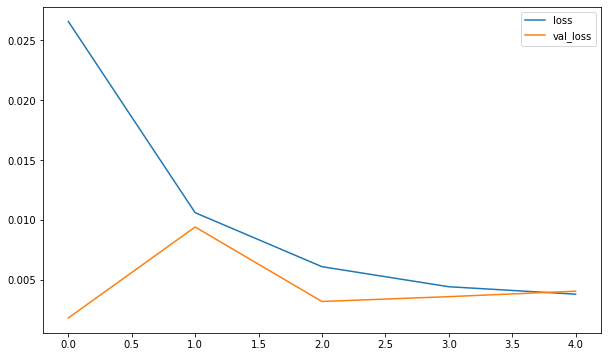

In [99]:
loss_df = pd.DataFrame(model2.history.history)
loss_df.plot();

#### Evaluate on Test Data

In [100]:
test_predictions = []

first_eval_batch = train_scaled[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):

    current_pred = model2.predict(current_batch)[0]

    test_predictions.append(current_pred) 
 
    current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis=1)

#### Inverse Transformations and Comparing

In [112]:
true_predictions = scaler.inverse_transform(test_predictions)

In [102]:
test

,Production,Predictions
DATE,,
2018-04-01,112.4309,118.116120
2018-05-01,110.3544,125.509953
2018-06-01,124.5841,129.115517
2018-07-01,117.2215,125.260993
2018-08-01,112.6779,113.106063
2018-09-01,103.3118,94.671794
2018-10-01,92.1321,78.923014
2018-11-01,82.4347,73.697403
2018-12-01,76.7608,81.260327


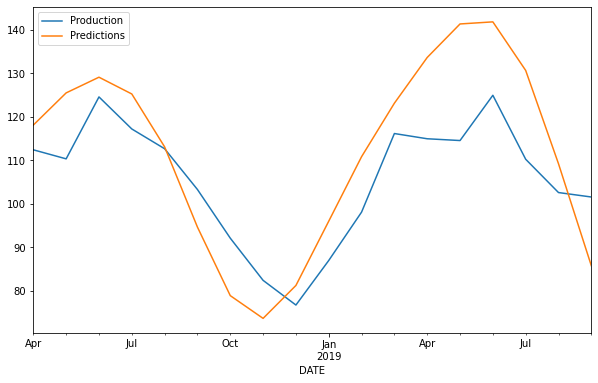

In [104]:
test.plot();

#### Calculation R2 Score and Error Metrics

In [108]:
def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    mse = mean_squared_error(actual, pred)
    score = r2_score(actual, pred)
    return print("r2_score:", score, "\nmae:", mae, "\nmse:",mse, "\nrmse:",rmse)

In [109]:
eval_metrics(test['Production'], test['Predictions'])

r2_score: 0.06934268711791736 
mae: 11.267761544461383 
mse: 169.2374673856212 
rmse: 13.009130154842067


## Retrain and Forecasting

Select activation function providing a better score, create your final model with full data, forecast for the next 12 months, and plot this forecast.

In [113]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)

In [114]:
scaled_full_data = full_scaler.fit_transform(df)

In [115]:
length = 18 
generator = TimeseriesGenerator(scaled_full_data, scaled_full_data, length = length, batch_size = 1)

In [116]:
model = Sequential()
model.add(LSTM(150, activation = 'relu', input_shape = (length, n_features)))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mse')

model.fit_generator(generator, epochs=8)

Epoch 1/8
555/555 [==============================] - 6s 8ms/step - loss: 0.0277
Epoch 2/8
555/555 [==============================] - 5s 8ms/step - loss: 0.0088
Epoch 3/8
555/555 [==============================] - 5s 9ms/step - loss: 0.0043
Epoch 4/8
555/555 [==============================] - 5s 9ms/step - loss: 0.0038
Epoch 5/8
555/555 [==============================] - 5s 8ms/step - loss: 0.0033
Epoch 6/8
555/555 [==============================] - 6s 10ms/step - loss: 0.0032
Epoch 7/8
555/555 [==============================] - 4s 8ms/step - loss: 0.0030
Epoch 8/8
555/555 [==============================] - 5s 8ms/step - loss: 0.0027


In [117]:
forecast = []

periods = 8

first_eval_batch = scaled_full_data[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(periods):
    
    current_pred = model.predict(current_batch)[0]
    
    forecast.append(current_pred) 
    
    current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis = 1)

In [118]:
forecast = scaler.inverse_transform(forecast)

In [119]:
forecast

array([[ 86.81598843],
       [ 77.91974174],
       [ 78.40416934],
       [ 91.31894716],
       [101.95036341],
       [110.58540714],
       [117.99943545],
       [123.97276662]])

In [120]:
df

,Production
DATE,
1972-01-01,59.9622
1972-02-01,67.0605
1972-03-01,74.2350
1972-04-01,78.1120
1972-05-01,84.7636
...,...
2019-05-01,114.5613
2019-06-01,124.9605
2019-07-01,110.2632


In [121]:
forecast_index = pd.date_range(start = '2019-10-01', periods = periods, freq = 'MS')

In [122]:
forecast_index

DatetimeIndex(['2019-10-01', '2019-11-01', '2019-12-01', '2020-01-01',
               '2020-02-01', '2020-03-01', '2020-04-01', '2020-05-01'],
              dtype='datetime64[ns]', freq='MS')

In [123]:
forecast_df = pd.DataFrame(data = forecast, index = forecast_index, columns = ['Forecast'])

In [124]:
forecast_df

,Forecast
2019-10-01,86.815988
2019-11-01,77.919742
2019-12-01,78.404169
2020-01-01,91.318947
2020-02-01,101.950363
2020-03-01,110.585407
2020-04-01,117.999435
2020-05-01,123.972767


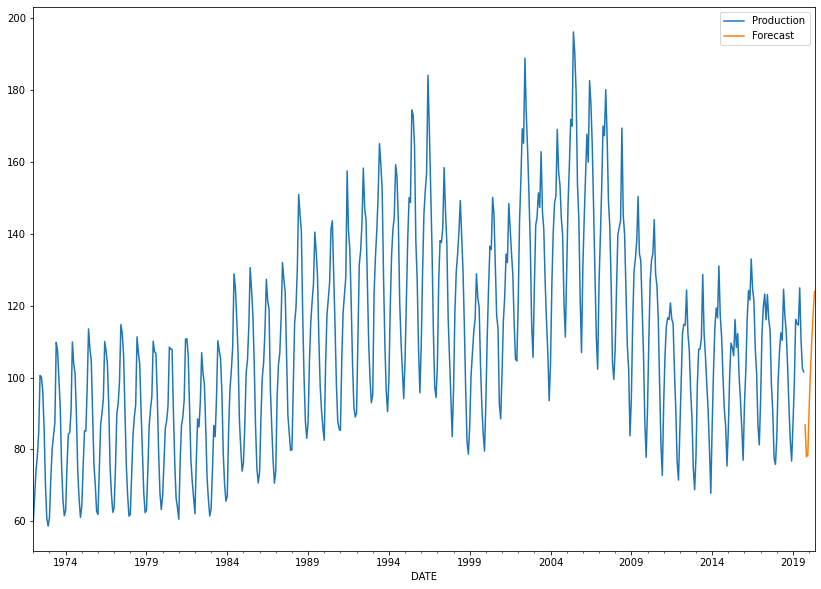

In [125]:
ax = df.plot()
forecast_df.plot(ax = ax, figsize = (14, 10));

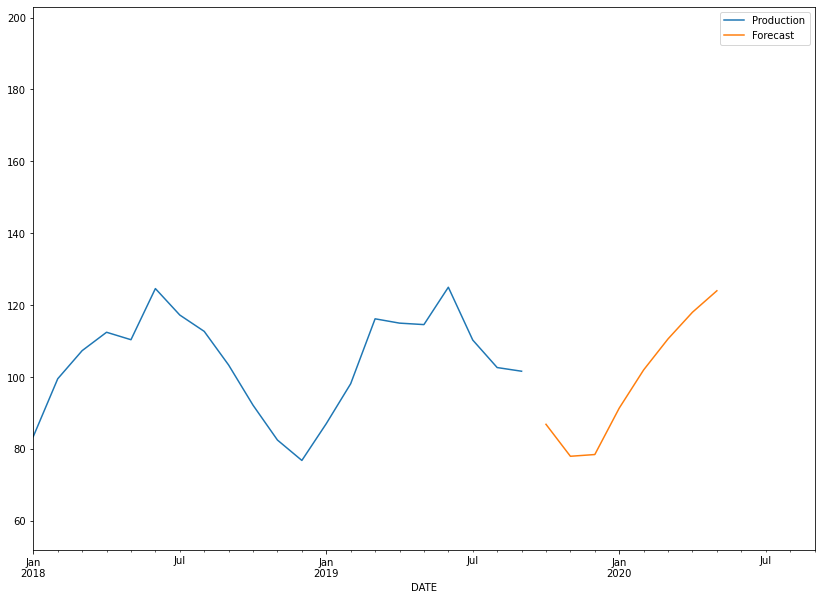

In [128]:
ax = df.plot()
forecast_df.plot(ax = ax, figsize = (14, 10))
plt.xlim('2018-01-01', '2020-09-01');